In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
df = pd.read_csv('32100364/32100364.csv',low_memory=False)
df.head()

,REF_DATE,GEO,DGUID,Estimates,Commodity,"Farm area, production, value",UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1926,Canada,2016A000011124,Marketed production,Fresh apples [114114111],Bushels,Bushels,42,thousands,3,v74253,1.1.1.1,8903.0,NaN,NaN,t,0
1,1926,Canada,2016A000011124,Marketed production,Fresh blueberries [1141114],Pounds,Pounds,254,thousands,3,v74308,1.1.2.3,0.0,NaN,NaN,t,0
2,1926,Canada,2016A000011124,Marketed production,Fresh grapes [1141147],Pounds,Pounds,254,thousands,3,v74391,1.1.3.3,24000.0,NaN,NaN,t,0
3,1926,Canada,2016A000011124,Marketed production,Fresh peaches [114114411],Bushels,Bushels,42,thousands,3,v74418,1.1.4.1,238.0,NaN,NaN,t,0
4,1926,Canada,2016A000011124,Marketed production,Fresh pears [114114211],Bushels,Bushels,42,thousands,3,v74439,1.1.5.1,275.0,NaN,NaN,t,0


In [2]:
df_bcbb = df.query('GEO == "British Columbia" & Commodity == "Fresh blueberries [1141114]" & Estimates == "Average price per pound"')
np.max(df_bcbb["REF_DATE"]),np.max(df_bcbb["VALUE"]) # we later derive this value using regression

(1981, 0.66)

Text(0.5, 1.0, 'Types of Estimates')

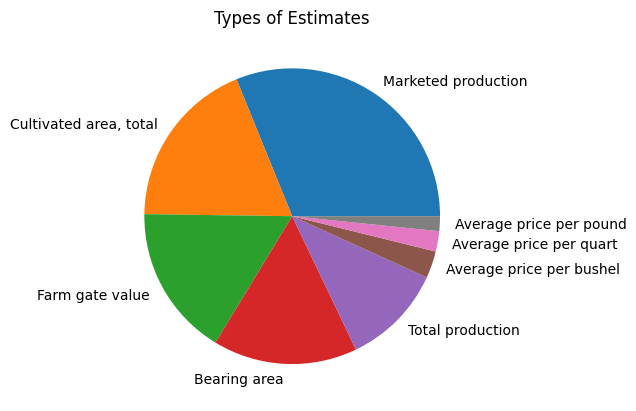

In [3]:
axisplot = df['Estimates'].value_counts().plot
pieplot = axisplot.pie()
pieplot.set_ylabel('')
pieplot.set_title('Types of Estimates')

Text(0.5, 1.0, 'Farm area, production, value')

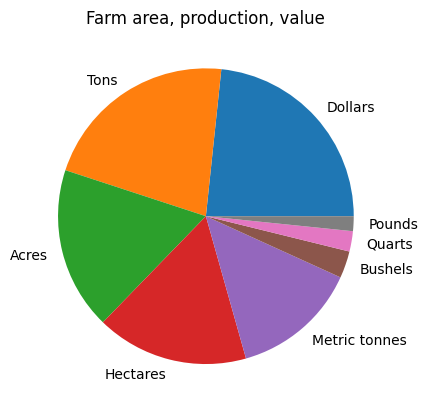

In [4]:
axisplot = df['Farm area, production, value'].value_counts().plot
pieplot = axisplot.pie()
pieplot.set_ylabel('')
pieplot.set_title('Farm area, production, value')

In [5]:
df_hectare = df[df['Farm area, production, value'] == 'Hectares']
df_acre = df[df['Farm area, production, value'] == 'Acres']

df_hectare = df_hectare.dropna(subset=['VALUE'],axis=0)
df_acre = df_acre.dropna(subset=['VALUE'],axis=0)

In [6]:
df_pounds = df[df['Farm area, production, value'] == 'Pounds']
df_tons = df[df['Farm area, production, value'] == 'Tons']
df_mtonnes = df[df['Farm area, production, value'] == 'Metric tonnes']

df_pounds = df_pounds.dropna(subset=['VALUE'],axis=0)
df_tons = df_tons.dropna(subset=['VALUE'],axis=0)
df_mtonnes = df_mtonnes.dropna(subset=['VALUE'],axis=0)

In [7]:
df_hectare['VALUE_acre'] = df_hectare['VALUE'] * 2.47105
df_hectare.drop('VALUE',inplace=True,axis=1)
df_hectare.rename(columns={'VALUE_acre':'VALUE'},inplace=True)

df_acre = pd.concat([df_hectare,df_acre],axis=0,ignore_index=True)
df_acre.head(5)

,REF_DATE,GEO,DGUID,Estimates,Commodity,"Farm area, production, value",UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,STATUS,SYMBOL,TERMINATED,DECIMALS,VALUE
0,2002,Canada,2016A000011124,"Cultivated area, total",Fresh apples [114114111],Hectares,Hectares,149,units,0,v52150947,1.6.1.8,NaN,NaN,NaN,0,60595.08810
1,2002,Canada,2016A000011124,"Cultivated area, total",Fresh blueberries [1141114],Hectares,Hectares,149,units,0,v52150950,1.6.2.8,NaN,NaN,NaN,0,123945.39695
2,2002,Canada,2016A000011124,"Cultivated area, total",Fresh grapes [1141147],Hectares,Hectares,149,units,0,v52150953,1.6.3.8,NaN,NaN,NaN,0,26104.17220
3,2002,Canada,2016A000011124,"Cultivated area, total",Fresh nectarines [114114421],Hectares,Hectares,149,units,0,v52150983,1.6.13.8,NaN,NaN,NaN,0,1060.08045
4,2002,Canada,2016A000011124,"Cultivated area, total",Fresh peaches [114114411],Hectares,Hectares,149,units,0,v52150956,1.6.4.8,NaN,NaN,NaN,0,8055.62300


In [8]:
df_pounds['VALUE_kg'] = df_pounds['VALUE'] * 0.453592
df_tons['VALUE_kg'] = df_tons['VALUE'] * 907.185
df_mtonnes['VALUE_kg'] = df_mtonnes['VALUE'] * 1000

#drop inplace
df_pounds.drop('VALUE',inplace=True,axis=1)
df_tons.drop('VALUE',inplace=True,axis=1)
df_mtonnes.drop('VALUE',inplace=True,axis=1)
df_pounds.rename(columns={'VALUE_kg':'VALUE'},inplace=True)
df_tons.rename(columns={'VALUE_kg':'VALUE'},inplace=True)
df_mtonnes.rename(columns={'VALUE_kg':'VALUE'},inplace=True)

df_kg = pd.concat([df_pounds,df_tons,df_mtonnes],axis=0,ignore_index=True)
df_kg = df_kg[(df_kg['GEO'] != 'Maritime provinces') & (df_kg['GEO'] != 'Atlantic provinces')]

In [9]:
df_acre_clean = df_acre.dropna(how='all',axis=1)
df_acre_clean = df_acre.dropna(how='all',axis=0)
df_acre_clean['Farm area, production, value'].value_counts()

Acres       5669
Hectares    5291
Name: Farm area, production, value, dtype: int64

In [10]:
drop_cols_area = ['Estimates','Farm area, production, value','UOM','SCALAR_FACTOR','DECIMALS','SYMBOL']
drop_cols_area.extend(['DGUID','UOM_ID','COORDINATE','STATUS','TERMINATED','VECTOR','SCALAR_ID'])
df_acre_clean = df_acre_clean.drop(drop_cols_area,axis=1)

In [11]:
df_kg_clean = df_kg.dropna(how='all',axis=1)
df_kg_clean = df_kg.dropna(how='all',axis=0)
df_kg_clean.shape
drop_cols = ['Estimates','Farm area, production, value','UOM','SCALAR_FACTOR','DECIMALS','SYMBOL']
drop_cols.extend(['DGUID','UOM_ID','COORDINATE','STATUS','TERMINATED','VECTOR','SCALAR_ID'])
df_kg_clean = df_kg_clean.drop(drop_cols,axis=1)

<AxesSubplot: ylabel='GEO,Commodity'>

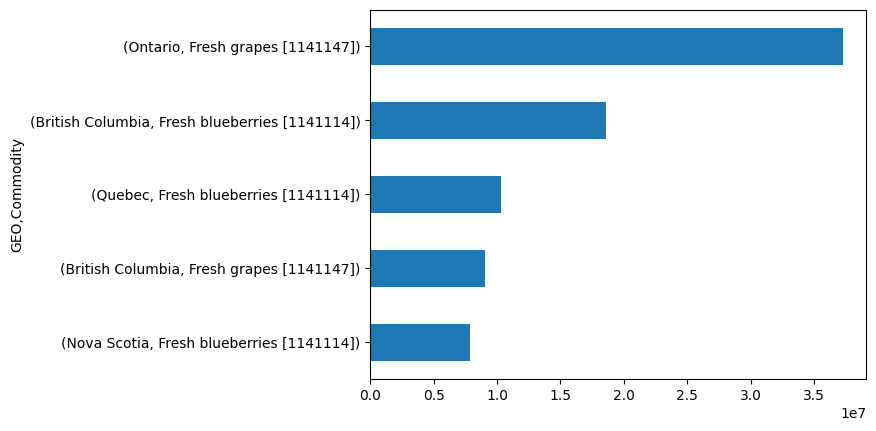

In [12]:
df_kg_plot = df_kg_clean[(df_kg_clean['Commodity']=='Fresh blueberries [1141114]') | (df_kg_clean['Commodity']=='Fresh grapes [1141147]')]
df_kg_plot.groupby(['GEO','Commodity'])['VALUE'].agg(np.mean).sort_values(ascending=True)[15:20].plot.barh()

In [13]:
df = df[(df['GEO'] != 'Maritime provinces') & (df['GEO'] != 'Atlantic provinces')]
df = df[df['Estimates'] == 'Average price per pound']

In [14]:
df_clean = df.dropna(how='all',axis=1)
df_clean = df_clean.dropna(how='all',axis=0)
df_clean = df_clean.drop(['DGUID','UOM_ID','COORDINATE','STATUS','TERMINATED','VECTOR','SCALAR_ID'],axis=1)

In [15]:
df_dollars = df_clean[df_clean['UOM'] == 'Dollars']
df_dollars = df_dollars.dropna(subset=['VALUE'],axis=0)

In [16]:
df_dollars.groupby(['Commodity','GEO'])['VALUE'].agg(np.mean).sort_values(ascending=False)

Commodity                    GEO                      
Fresh blueberries [1141114]  British Columbia             0.151964
                             Quebec                       0.143750
                             Canada                       0.136400
                             Nova Scotia                  0.114107
                             New Brunswick                0.113393
                             Prince Edward Island         0.109286
                             Newfoundland and Labrador    0.084821
Fresh grapes [1141147]       British Columbia             0.071964
                             Canada                       0.055000
                             Ontario                      0.053393
Name: VALUE, dtype: float64

In [17]:
df_dollars = df_dollars.drop(['Estimates','Farm area, production, value','UOM','SCALAR_FACTOR','DECIMALS'],axis=1)

In [18]:
df_bb = df_dollars[df_dollars['Commodity'] == 'Fresh blueberries [1141114]']
df_gr = df_dollars[df_dollars['Commodity'] == 'Fresh grapes [1141147]']

df_bbkg = df_kg_clean[df_kg_clean['Commodity'] == 'Fresh blueberries [1141114]']
df_grkg = df_kg_clean[df_kg_clean['Commodity'] == 'Fresh grapes [1141147]']

df_bbacre = df_acre_clean[df_acre_clean['Commodity'] == 'Fresh blueberries [1141114]']
df_gracre = df_acre_clean[df_acre_clean['Commodity'] == 'Fresh grapes [1141147]']

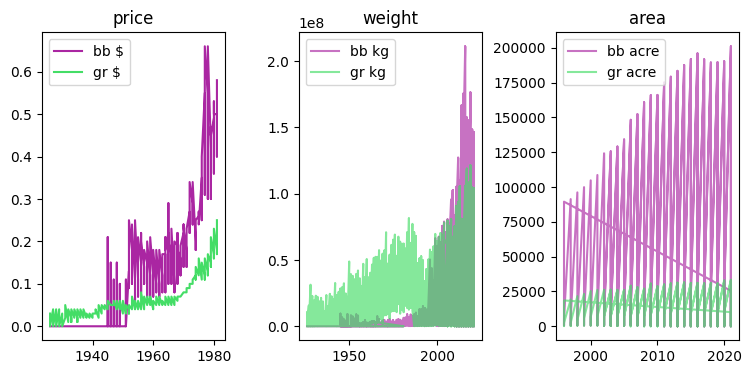

In [19]:
bbcolor = '#aa26a2'
grcolor = '#44dd66'
fig, (axa,axb,axc) = plt.subplots(1,3)
fig.set_size_inches(9, 4)
X_bb = df_bb.drop('VALUE',axis=1)
y_bb = df_bb['VALUE']
X_gr = df_gr.drop('VALUE',axis=1)
y_gr = df_gr['VALUE']
axa.plot(df_bb['REF_DATE'],y_bb,color=bbcolor)
axa.plot(df_gr['REF_DATE'],y_gr,color=grcolor)
axa.legend(['bb $','gr $'])
axa.set_title('price')

X_bbkg = df_bbkg.drop('VALUE',axis=1)
y_bbkg = df_bbkg['VALUE']
X_grkg = df_grkg.drop('VALUE',axis=1)
y_grkg = df_grkg['VALUE']
axb.plot(df_bbkg['REF_DATE'],y_bbkg,color=bbcolor,alpha=0.65)
axb.plot(df_grkg['REF_DATE'],y_grkg,color=grcolor,alpha=0.65)
axb.legend(['bb kg','gr kg'])
axb.set_title('weight')

X_bbacre = df_bbacre.drop('VALUE',axis=1)
y_bbacre = df_bbacre['VALUE']
X_gracre = df_gracre.drop('VALUE',axis=1)
y_gracre = df_gracre['VALUE']
axc.plot(df_bbacre['REF_DATE'],y_bbacre,color=bbcolor,alpha=0.65)
axc.plot(df_gracre['REF_DATE'],y_gracre,color=grcolor,alpha=0.65)
axc.legend(['bb acre','gr acre'])
axc.set_title('area')

plt.subplots_adjust(wspace=0.4,hspace=0.4)

In [20]:
df_bbacre.groupby('GEO')['VALUE'].agg(np.mean).sort_values(ascending=False)[:5]

GEO
Canada              134298.463234
Quebec               50233.702357
Nova Scotia          31068.363516
New Brunswick        24156.692223
British Columbia     18423.210774
Name: VALUE, dtype: float64

In [21]:
df_gracre.groupby('GEO')['VALUE'].agg(np.mean).sort_values(ascending=False)[:5]

GEO
Canada              28318.556048
Ontario             17692.326086
British Columbia     8646.050793
Quebec               1314.554375
Nova Scotia           596.874591
Name: VALUE, dtype: float64

In [22]:
df_bb.groupby('GEO')['VALUE'].agg(np.mean).sort_values(ascending=False)[:5]

GEO
British Columbia    0.151964
Quebec              0.143750
Canada              0.136400
Nova Scotia         0.114107
New Brunswick       0.113393
Name: VALUE, dtype: float64

In [23]:
df_gr.groupby('GEO')['VALUE'].agg(np.mean).sort_values(ascending=False)[:5]

GEO
British Columbia    0.071964
Canada              0.055000
Ontario             0.053393
Name: VALUE, dtype: float64

In [24]:
df_tp = df_bb[(df_bb['GEO'] == 'Newfoundland and Labrador') | (df_bb['GEO'] == 'British Columbia') | (df_bb['GEO'] == 'Quebec') | (df_bb['GEO'] == 'Canada') ]
df_tp.groupby('GEO')['VALUE'].agg(np.mean).sort_values(ascending=False)

GEO
British Columbia             0.151964
Quebec                       0.143750
Canada                       0.136400
Newfoundland and Labrador    0.084821
Name: VALUE, dtype: float64

In [25]:
X = df_bb[['REF_DATE','GEO']]
y = df_bb['VALUE']
X['GEO'].value_counts()

Newfoundland and Labrador    56
Prince Edward Island         56
Nova Scotia                  56
New Brunswick                56
Quebec                       56
British Columbia             56
Canada                       50
Name: GEO, dtype: int64

In [26]:
Xcat = pd.get_dummies(X[['GEO']],dummy_na=False,drop_first=False)
Xnew = pd.concat([ X['REF_DATE'],Xcat ],axis=1)
Xnew.head(5)

,REF_DATE,GEO_British Columbia,GEO_Canada,GEO_New Brunswick,GEO_Newfoundland and Labrador,GEO_Nova Scotia,GEO_Prince Edward Island,GEO_Quebec
10,1926,0,1,0,0,0,0,0
27,1926,0,0,0,1,0,0,0
51,1926,0,0,0,0,0,1,0
70,1926,0,0,0,0,1,0,0
88,1926,0,0,1,0,0,0,0


<BarContainer object of 8 artists>

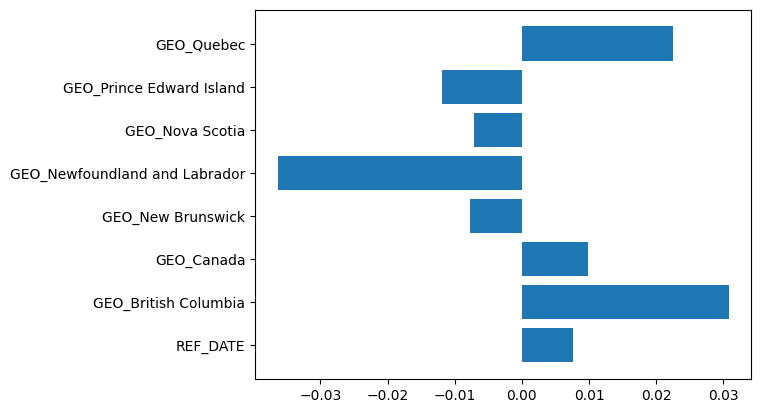

In [27]:
lrmodel = LinearRegression().fit(Xnew.values, y.values)
plt.barh(Xnew.columns,lrmodel.coef_)

In [28]:
priceInCanada2025 = {
    'REF_DATE':2025,
    'GEO_British Columbia':0,
    'GEO_Canada':1,
    'GEO_New Brunswick':0,
    'GEO_Newfoundland and Labrador':0,
    'GEO_Nova Scotia':0,
    'GEO_Prince Edward Island':0,
    'GEO_Quebec':0
}
priceInNewBrunswick2025 = {
    'REF_DATE':2025,
    'GEO_British Columbia':0,
    'GEO_Canada':0,
    'GEO_New Brunswick':1,
    'GEO_Newfoundland and Labrador':0,
    'GEO_Nova Scotia':0,
    'GEO_Prince Edward Island':0,
    'GEO_Quebec':0
}
priceInBC2025 = {
    'REF_DATE':2025,
    'GEO_British Columbia':1,
    'GEO_Canada':0,
    'GEO_New Brunswick':0,
    'GEO_Newfoundland and Labrador':0,
    'GEO_Nova Scotia':0,
    'GEO_Prince Edward Island':0,
    'GEO_Quebec':0
}

In [29]:
inputList = list(priceInCanada2025.values())
priceInCanada2025_result = lrmodel.predict(np.array(inputList).reshape(1,-1))

inputList = list(priceInNewBrunswick2025.values())
priceInNewBrunswick2025_result = lrmodel.predict(np.array(inputList).reshape(1,-1))

inputList = list(priceInBC2025.values())
priceInBC2025_result = lrmodel.predict(np.array(inputList).reshape(1,-1))

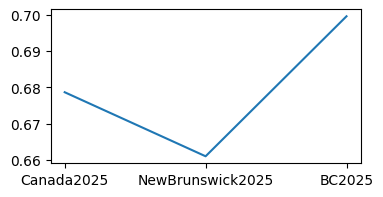

In [30]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(4, 2)
ax.plot(['Canada2025','NewBrunswick2025','BC2025'],
        [priceInCanada2025_result[0],
         priceInNewBrunswick2025_result[0],
         priceInBC2025_result[0]])